In [9]:
import boto3
import pandas as pd
from datetime import datetime
from numpy import isnan
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

In [2]:
def parse(x):
    x = pd.to_numeric(x, downcast='float')
    return pd.Timestamp(x, unit='s')

# Function to convert date columns into a single timestamp field
#def parse(x):
#    return datetime.strptime(x, '%Y %m %d %H')

# def parse(x):
#     t= pd.to_datetime(str(x)) 
#     timestring = t.strftime('%Y.%m.%d %H:%M:%S')
#     return timestring

def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if np.isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

In [3]:
client = boto3.client('iotanalytics')
dataset = "iot_data_dataset_container"
data_location = client.get_dataset_content(datasetName = dataset)['entries'][0]['dataURI']
df = pd.read_csv(data_location,
                      header=0, 
                      low_memory=False, 
                      infer_datetime_format=True, 
                      date_parser=parse,
                      index_col=['ts'])

In [11]:
print(df.head(5))

                                 device   humidity       temp  light  motion  \
ts                                                                             
2020-07-02 00:21:20  iot-demo-device-02  69.099998  63.680001   True   False   
2020-07-02 00:21:20  iot-demo-device-01  71.099998  65.119999  False   False   
2020-07-02 00:21:20  iot-demo-device-03  48.900002  71.600000  False   False   
2020-07-02 00:21:20  iot-demo-device-03  49.000000  71.600000  False   False   
2020-07-02 00:21:20  iot-demo-device-01  71.099998  64.939999  False   False   

                          lpg        co     smoke                     __dt  
ts                                                                          
2020-07-02 00:21:20  0.009247  0.006440  0.024991  2020-07-02 00:00:00.000  
2020-07-02 00:21:20  0.008360  0.005602  0.022440  2020-07-02 00:00:00.000  
2020-07-02 00:21:20  0.008065  0.005331  0.021594  2020-07-02 00:00:00.000  
2020-07-02 00:21:20  0.008071  0.005336  0.021611  202

In [5]:
print(df.count())

device      489637
humidity    489637
temp        489637
light       489637
motion      489637
lpg         489637
co          489637
smoke       489637
__dt        489637
dtype: int64


In [18]:
df_filtered = df.sort_values(ascending=False, by='ts').head(10000)

q_low = df_filtered["humidity"].quantile(0.01)
q_hi  = df_filtered["humidity"].quantile(0.99)

df_filtered = df_filtered[(df_filtered["humidity"] < q_hi) & (df_filtered["humidity"] > q_low)]

q_low = df_filtered["temp"].quantile(0.01)
q_hi  = df_filtered["temp"].quantile(0.99)

df_filtered = df_filtered[(df_filtered["temp"] < q_hi) & (df_filtered["temp"] > q_low)]

groups = df_filtered.groupby('device')

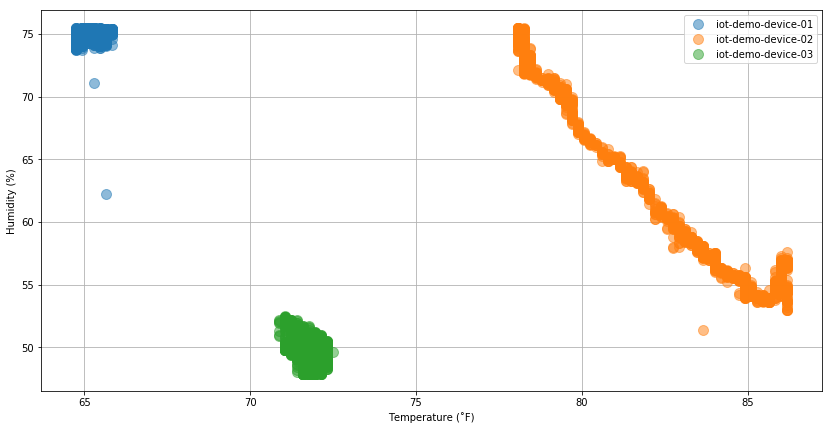

In [19]:
_, ax = plt.subplots(1, 1, figsize=(14,7))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for device, group in groups:
    ax.plot(group.temp, 
            group.humidity, 
            marker='o', 
            linestyle='', 
            alpha=.5,
            ms=10, 
            label=device)
ax.grid()
ax.legend()
plt.xlabel("Temperature (˚F)")
plt.ylabel("Humidity (%)")
plt.show()

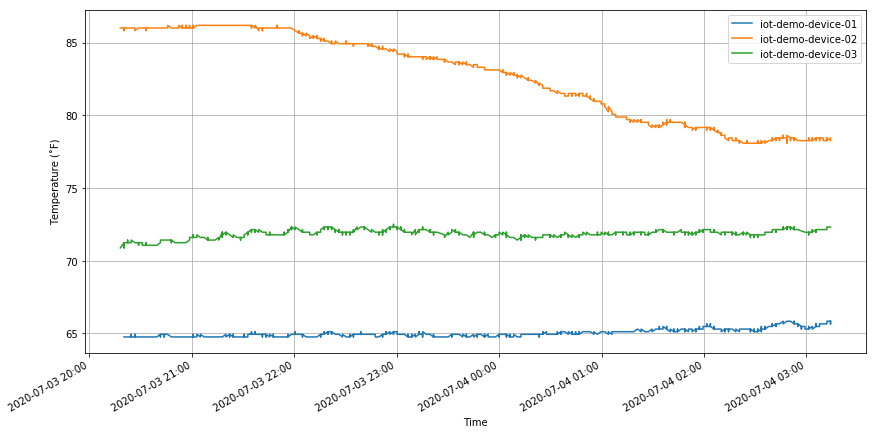

In [20]:
register_matplotlib_converters()
fig, ax = plt.subplots(1, 1, figsize=(14,7))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for device, group in groups:
    ax.plot(group.temp,
            label=device)
myFmt = DateFormatter("%Y-%m-%d %H:%M")
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
ax.grid()
ax.legend()
plt.ylabel("Temperature (˚F)")
plt.xlabel("Time")
plt.show()